### Check visualization when rotating vectors or not

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import sys
sys.path.append('/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection')
import sys
from config import system as config_sys
sys.path.append(f'{config_sys.project_code_root}/src')
from helpers.data_bern_numpy_to_preprocessed_hdf5 import interpolate_and_slice
from helpers.utils import normalize_image ,crop_or_pad_Bern_slices, skeleton_points, rotate_vectors
import os 
from skimage.morphology import cube, dilation
from IPython.display import HTML
from matplotlib.colors import Normalize


In [2]:
or_image = np.load(f'{config_sys.project_data_root}/preprocessed/controls/numpy/MACDAVD_101_.npy')
or_image.shape

(160, 110, 56, 23, 4)

In [3]:


# Define the size of the image
sizex, sizey, sizez, sizet, c_ = or_image.shape

# Create gradients for each channel
gradient_top_bottom = np.linspace(0, 1, sizey).reshape(1, sizey, 1, 1, 1).repeat(sizex, axis=0).repeat(sizez, axis=2).repeat(sizet, axis=3)
gradient_front_back = np.linspace(0, 1, sizez).reshape(1, 1, sizez, 1, 1).repeat(sizex, axis=0).repeat(sizey, axis=1).repeat(sizet, axis=3)
gradient_left_right = np.linspace(0, 1, sizex).reshape(sizex, 1, 1, 1, 1).repeat(sizey, axis=1).repeat(sizez, axis=2).repeat(sizet, axis=3)

# Stack the gradients along the last axis to create the image
image = np.concatenate((gradient_left_right, gradient_top_bottom, gradient_front_back), axis=-1)

print(image.shape)  # This should print (sizex, sizey, sizez, sizet, 3)


(160, 110, 56, 23, 3)


In [4]:
gradient_left_right = np.linspace(0, 1, sizex)[:, None, None, None]
gradient_top_bottom = np.linspace(0, 1, sizey)[None, :, None, None]
gradient_front_back = np.linspace(0, 1, sizez)[None, None, :, None]
image = np.zeros((sizex, sizey, sizez, sizet, 3))

# Assign the gradients to the corresponding channels
image[..., 0] = gradient_left_right
image[..., 1] = gradient_top_bottom
image[..., 2] = gradient_front_back

(-0.5, 109.5, 159.5, -0.5)

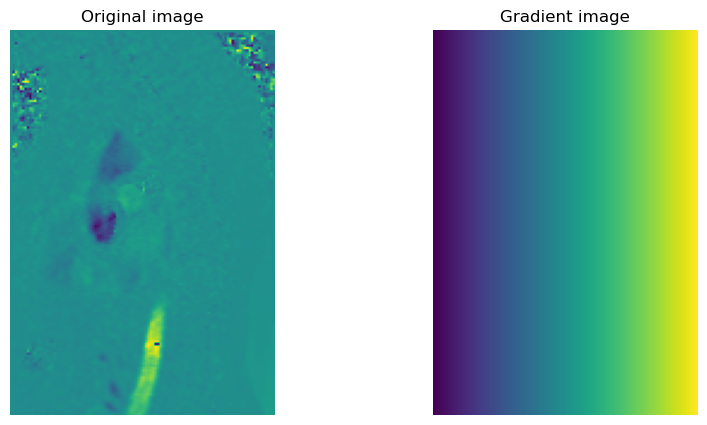

In [5]:
z_slice = 20
t_slice = 3
channel = 1
# Plot the two images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(or_image[:,:,z_slice,t_slice,channel])
plt.title('Original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image[:,:,z_slice,t_slice,channel])
plt.title('Gradient image')
plt.axis('off')

In [6]:
def verify_rotation_matrices():

    rotated_vectors_list = []
    
    for subject in os.listdir(f'{config_sys.project_data_root}/segmentations/segmenter_rw_pw_hard/controls/')[:1]:
        common_image_shape = [36, 36, 64, 24, 4] # [x, y, z, t, num_channels]
        end_shape = [32, 32, 64, 24, 4]

        image = np.load(f"{config_sys.project_data_root}/preprocessed/controls/numpy/{subject.split('seg_')[1]}")
        segmented_original = np.load(f'{config_sys.project_data_root}/segmentations/segmenter_rw_pw_hard/controls/{subject}')
        time_steps = segmented_original.shape[3]
        segmented = dilation(segmented_original[:,:,:,3], cube(3))
        temp_for_stack = [segmented for i in range(time_steps)]
        segmented = np.stack(temp_for_stack, axis=3)

        image = normalize_image(image)
        seg_shape = list(segmented.shape)
        seg_shape.append(image.shape[-1])
        image = crop_or_pad_Bern_slices(image, seg_shape)

        temp_images_intensity = image[:,:,:,:,0] * segmented # change these back if it works
        temp_images_vx = image[:,:,:,:,1] * segmented
        temp_images_vy = image[:,:,:,:,2] * segmented
        temp_images_vz = image[:,:,:,:,3] * segmented

        # recombine the images
        image = np.stack([temp_images_intensity,temp_images_vx,temp_images_vy,temp_images_vz], axis=4)

        points = skeleton_points(segmented_original, dilation_k = 2,erosion_k = 2)

        # Limit to sectors where ascending aorta is located
        points = points[np.where(points[:,1]<60)]
        points = points[np.where(points[:,0]<90)]

        # Order the points in ascending order with x
        points = points[points[:,0].argsort()[::-1]]

        temp = []
        for index, element in enumerate(points[2:]):
            if (index%2)==0:
                temp.append(element)


        coords = np.array(temp)

        # We create Slices across time and channels in a double for loop
        temp_for_channel_stacking = []
        geometry_saved = False
        for channel in range(image.shape[4]):

            temp_for_time_stacking = []
            for t in range(image.shape[3]):
                if not geometry_saved:
                    save_for_backtransformation = True
                else:
                    save_for_backtransformation = False
                slice_dict = interpolate_and_slice(image[:,:,:,t,channel], coords, common_image_shape)
                if save_for_backtransformation:
                    geometry_saved = True  
                    geometry_dict = slice_dict['geometry_dict']
                straightened = slice_dict['straightened']
                temp_for_time_stacking.append(straightened)

            channel_stacked = np.stack(temp_for_time_stacking, axis=-1)
            temp_for_channel_stacking.append(channel_stacked)

        straightened = np.stack(temp_for_channel_stacking, axis=-1)
        # Create the 3D fields
        x_dim = straightened.shape[0]
        y_dim = straightened.shape[1]
        z_dim = straightened.shape[2]
        x_field = np.zeros((x_dim, y_dim, z_dim))  
        y_field = np.zeros((x_dim, y_dim, z_dim))   
        z_field = np.ones((x_dim, y_dim, z_dim))  
        # Combine the fields into a single 4D array
        vector_field = np.stack((x_field, y_field, z_field), axis=-1)
        # We need to rotate the vectors as well loop through slices
        vector_field_rotated_vectors = vector_field.copy()
        for z_ in range(vector_field.shape[2]):
            
            rotation_matrix = np.array(slice_dict['geometry_dict'][f'slice_{z_}']['transform'].GetInverse().GetMatrix()).reshape(3,3)
            vectors_flat = vector_field[:,:,z_,1:].reshape(-1, 3)
            
            rotated_vectors_flat = np.dot(rotation_matrix, vectors_flat.T).T
            vector_field_rotated_vectors[:,:,z_,1:] = rotated_vectors_flat.reshape(vector_field[:,:,z_,1:].shape)
            
         
        rotated_vectors_list.append(vector_field_rotated_vectors)
    return rotated_vectors_list


    
rotated_vectors_list = verify_rotation_matrices()

100%|██████████| 1/1 [00:00<00:00, 399.08it/s]


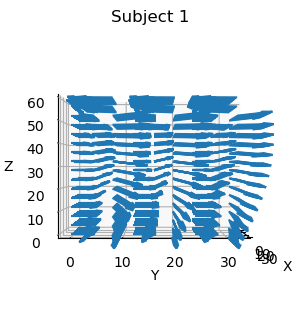

In [7]:
# Assuming rotated_vectors_list is your list of vector fields
n_subjects = len(rotated_vectors_list)
n = 4  # subsampling rate

# Define the grid for subplots
n_rows = 8  # You can adjust these based on your preference and screen resolution
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, subplot_kw={'projection': '3d'}, figsize=(3*n_cols, 3*n_rows))

for i, vector_field_rotated_vectors in enumerate(tqdm(rotated_vectors_list)):
    U = vector_field_rotated_vectors[:,:,:,0]
    V = vector_field_rotated_vectors[:,:,:,1]
    W = vector_field_rotated_vectors[:,:,:,2]

    # Create a subsampled meshgrid for the coordinates
    x = np.linspace(0, vector_field_rotated_vectors.shape[0]-1, vector_field_rotated_vectors.shape[0])[::n]
    y = np.linspace(0, vector_field_rotated_vectors.shape[1]-1, vector_field_rotated_vectors.shape[1])[::n]
    z = np.linspace(0, vector_field_rotated_vectors.shape[2]-1, vector_field_rotated_vectors.shape[2])[::n]
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # Subsample the vector components
    U_sub = U[::n, ::n, ::n]
    V_sub = V[::n, ::n, ::n]
    W_sub = W[::n, ::n, ::n]

    # Plotting
    ax = axs[i // n_cols, i % n_cols]
    ax.quiver(X, Y, Z, U_sub, V_sub, W_sub, length=5, normalize=False)

    ax.set_title(f'Subject {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set view angle
    ax.view_init(10, 30)  # Adjust as needed
    ax.view_init(0, 0)  # Adjust the viewing angle for better visualization

# Hide unused subplots
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axs[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()


In [8]:
common_image_shape = [36, 36, 64, 24, 4] # [x, y, z, t, num_channels]
end_shape = [32, 32, 64, 24, 4]

image = np.load(f"{config_sys.project_data_root}/preprocessed/controls/numpy/MACDAVD_119_.npy")
segmented_original = np.load(f'{config_sys.project_data_root}/segmentations/segmenter_rw_pw_hard/controls/seg_MACDAVD_119_.npy')
image.shape, segmented_original.shape

((160, 110, 56, 20, 4), (160, 110, 56, 20))

In [9]:
time_steps = segmented_original.shape[3]
segmented = dilation(segmented_original[:,:,:,3], cube(3))
temp_for_stack = [segmented for i in range(time_steps)]
segmented = np.stack(temp_for_stack, axis=3)

image = normalize_image(image)
seg_shape = list(segmented.shape)
seg_shape.append(image.shape[-1])
image = crop_or_pad_Bern_slices(image, seg_shape)

temp_images_intensity = image[:,:,:,:,0] * segmented # change these back if it works
temp_images_vx = image[:,:,:,:,1] * segmented
temp_images_vy = image[:,:,:,:,2] * segmented
temp_images_vz = image[:,:,:,:,3] * segmented

# recombine the images
image = np.stack([temp_images_intensity,temp_images_vx,temp_images_vy,temp_images_vz], axis=4)

points = skeleton_points(segmented_original, dilation_k = 2,erosion_k = 2)

# Limit to sectors where ascending aorta is located
points = points[np.where(points[:,1]<60)]
points = points[np.where(points[:,0]<90)]

# Order the points in ascending order with x
points = points[points[:,0].argsort()[::-1]]

temp = []
for index, element in enumerate(points[2:]):
    if (index%2)==0:
        temp.append(element)


coords = np.array(temp)

# We create Slices across time and channels in a double for loop
temp_for_channel_stacking = []
geometry_saved = False
for channel in range(image.shape[4]):

    temp_for_time_stacking = []
    for t in range(image.shape[3]):
        if not geometry_saved:
            save_for_backtransformation = True
        else:
            save_for_backtransformation = False
        slice_dict = interpolate_and_slice(image[:,:,:,t,channel], coords, common_image_shape)
        if save_for_backtransformation:
            geometry_saved = True  
            geometry_dict = slice_dict['geometry_dict']
        straightened = slice_dict['straightened']
        temp_for_time_stacking.append(straightened)

    channel_stacked = np.stack(temp_for_time_stacking, axis=-1)
    temp_for_channel_stacking.append(channel_stacked)

straightened = np.stack(temp_for_channel_stacking, axis=-1)
straightened.shape


(36, 36, 64, 20, 4)

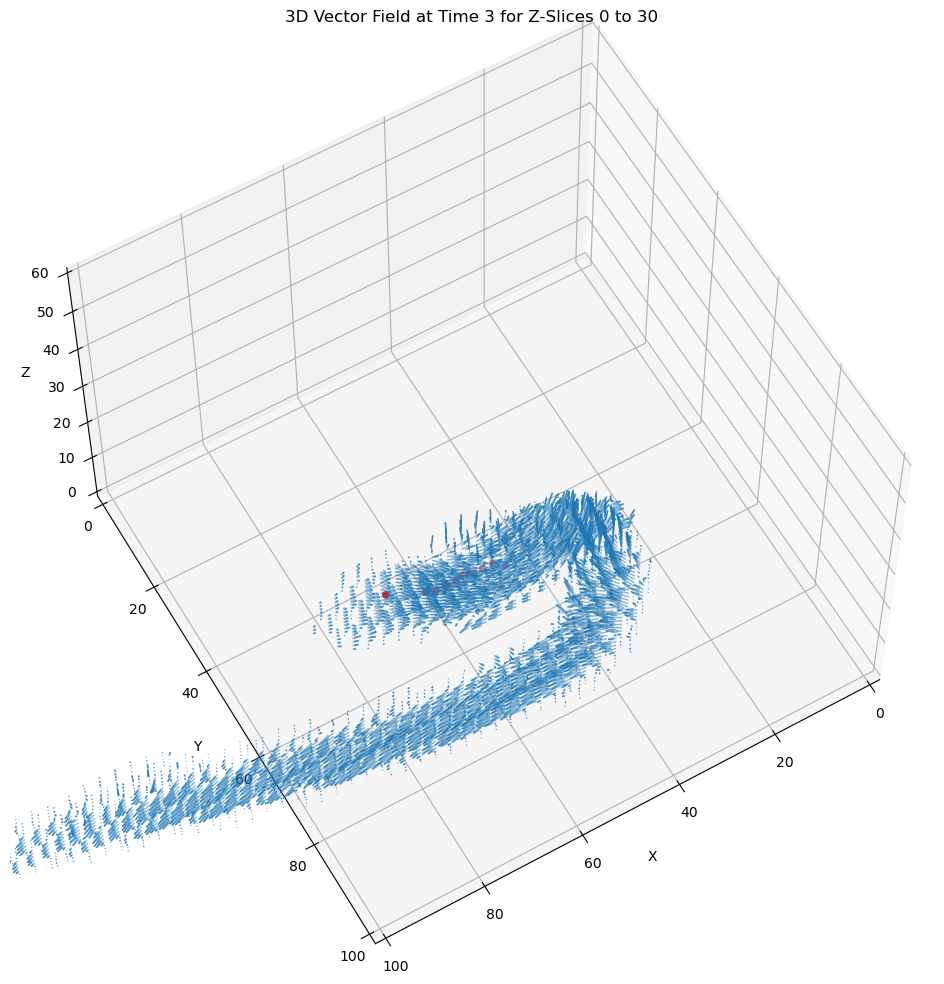

In [10]:
image_crop = image[30:50,20:80,:,:,:]
#image_crop = image[20:80,30:50,:,:,:]
# Extracting vector components for time point t
t = 3  # replace with your desired time point
vx = image[:, :, :, t, 1]  # vx component
vy = image[:, :, :, t, 2]  # vy component
vz = image[:, :, :, t, 3]  # vz component



# Define the range of slices to visualize
start_slice = 0  # Starting slice number
end_slice = 30    # Ending slice number

# Set up the figure and 3D axis
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Sampling rate for arrows
n = 3  # Sample every nth arrow


for z in range(start_slice, end_slice + 1):
    x, y = np.meshgrid(np.arange(0, image.shape[0], n), np.arange(0, image.shape[1], n))  # Swapping x and y here
    ax.quiver(x, y, z, vx[::n, ::n, z].T, vy[::n, ::n, z].T, vz[::n, ::n, z].T, length=5, linewidths=1, arrow_length_ratio=0.7, alpha=0.5)


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f"3D Vector Field at Time {t} for Z-Slices {start_slice} to {end_slice}")
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_zlim(0, 60)
#ax.set_zlim(0, 60)
#ax.set_xlim(20, 80)
#ax.set_ylim(20, 50)
#ax.set_ylim(50, 100)
views = [(30, -60), (90, -90), (0, -90), (0, 0)]  # angles for elevation and azimuth


# Plot the points
ax.scatter(coords[:,0], coords[:,1], coords[:,2], c='r', marker='o')



#ax.view_init(elev=270., azim=270)
ax.view_init(60,60)
#ax.view_init(70,130)
#ax.view_init(60,100)
#ax.view_init(0,0)
n_view = 1
#ax.view_init(views[n_view][0],views[n_view][1])


# Show the plot
plt.show()


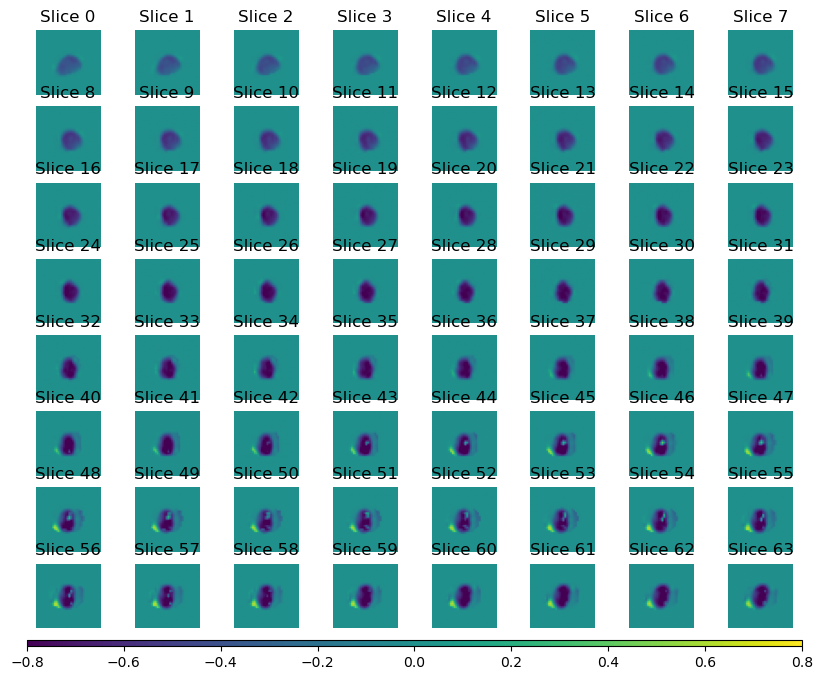

In [11]:
fig = plt.figure(figsize=(10, 8))  # Adjusted figure size to accommodate colorbar
gs = gridspec.GridSpec(9, 8, height_ratios=[1]*8 + [0.1])  # Adding extra row for colorbar

# Define the color range
vmin, vmax = -0.8, 0.8

for i in range(64):
    ax = plt.subplot(gs[i])
    im = ax.imshow(straightened[:,:,i,3,1], vmin=vmin, vmax=vmax)
    # Set title
    ax.set_title(f"Slice {i}")
    ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')

# Create a colorbar in the last row of the grid
cbar_ax = plt.subplot(gs[-1, :])
plt.colorbar(im, cax=cbar_ax, orientation='horizontal')

plt.show()


In [12]:
# We need to rotate the vectors as well loop through slices
straightened_rotated_vectors = straightened.copy()
for z_ in range(straightened.shape[2]):
    for t_ in range(straightened.shape[3]):
        rotation_matrix = np.array(slice_dict['geometry_dict'][f'slice_{z_}']['transform'].GetInverse().GetMatrix()).reshape(3,3)
        
        straightened_rotated_vectors[:,:,z_,t_,1:] = rotate_vectors(straightened[:,:,z_,t_,1:], rotation_matrix)


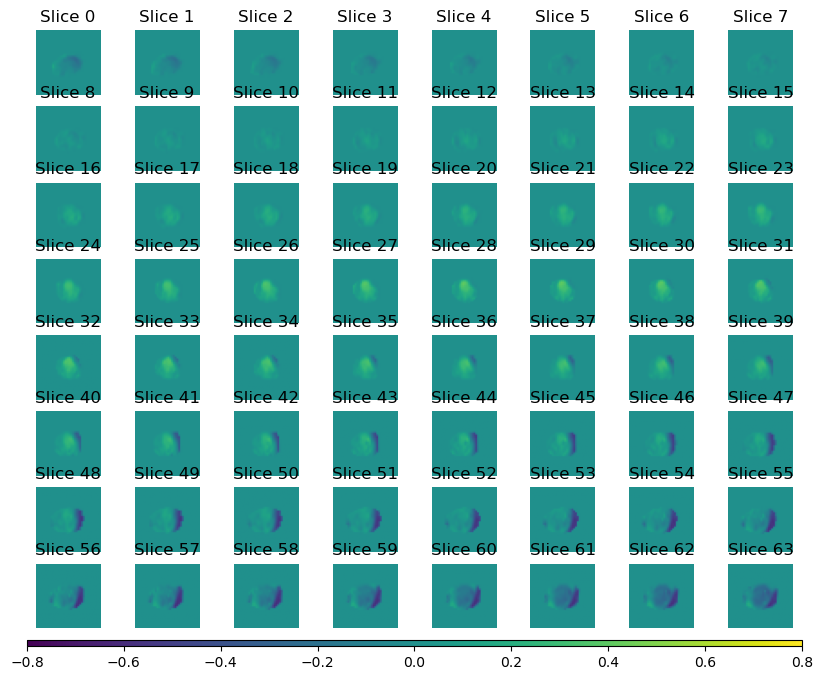

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fig = plt.figure(figsize=(10, 8))  # Adjusted figure size to accommodate colorbar
gs = gridspec.GridSpec(9, 8, height_ratios=[1]*8 + [0.1])  # Adding extra row for colorbar

# Define the color range
vmin, vmax = -0.8, 0.8

for i in range(64):
    ax = plt.subplot(gs[i])
    im = ax.imshow(straightened_rotated_vectors[:,:,i,3,1], vmin=vmin, vmax=vmax)
    # Set title
    ax.set_title(f"Slice {i}")
    ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')

# Create a colorbar in the last row of the grid
cbar_ax = plt.subplot(gs[-1, :])
plt.colorbar(im, cax=cbar_ax, orientation='horizontal')

plt.show()


In [14]:
rotation_matrix = np.array(slice_dict['geometry_dict'][f'slice_{z_}']['transform'].GetInverse().GetMatrix()).reshape(3,3)
        
straightened_rotated_vectors[:,:,z_,t_,1:] = rotate_vectors(straightened[:,:,z_,t_,1:], rotation_matrix)

In [15]:
t = 3
vx_old = straightened[:, :, :, t, 1]  # Extracting vx
vy_old = straightened[:, :, :, t, 2]  # Extracting vy
vz_old = straightened[:, :, :, t, 3]  # Extracting vz

vx = straightened_rotated_vectors[:, :, :, t, 1]  # Extracting vx
vy = straightened_rotated_vectors[:, :, :, t, 2]  # Extracting vy
vz = straightened_rotated_vectors[:, :, :, t, 3]  # Extracting vz

2024-10-31 14:21:29,768 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-10-31 14:21:29,769 MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x1000 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpqf9bwjfu/temp.m4v
2024-10-31 14:21:30,166 MovieWriter stderr:
[libopenh264 @ 0x5577556233c0] Incorrect library version loaded
Error initializing output stream 0:0 -- Error while opening encoder for output stream #0:0 - maybe incorrect parameters such as bit_rate, rate, width or height



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x1000', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpqf9bwjfu/temp.m4v']' returned non-zero exit status 1.

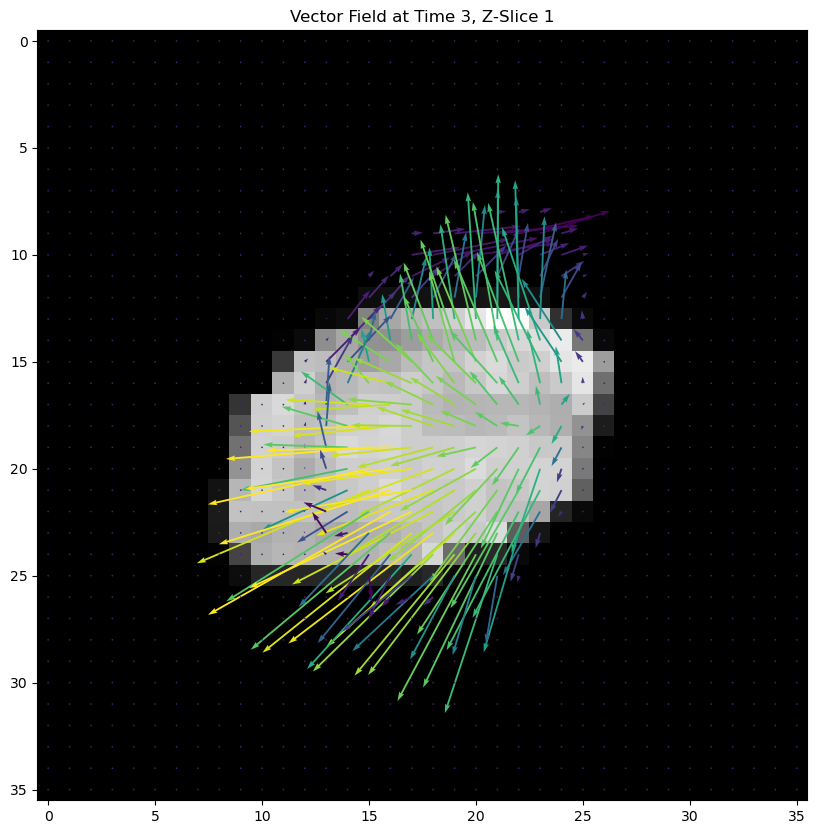

In [17]:
plt.close()
%matplotlib inline
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 10))
x, y = np.meshgrid(np.arange(straightened_rotated_vectors.shape[0]), np.arange(straightened_rotated_vectors.shape[1]))
quiver = ax.quiver(x, y, vx[:, :, 0].T, vy[:, :, 0].T, vz[:, :, 0].T)

# Update function for animation
def update(z_slice):
    quiver.set_UVC(vx[:, :, z_slice].T, vy[:, :, z_slice].T, vz[:, :, z_slice].T)
    plt.imshow(straightened_rotated_vectors[:, :, z_slice, 3, 0], cmap='gray')
    ax.set_title(f"Vector Field at Time {t}, Z-Slice {z_slice}")
    return quiver,

# Create the animation
ani = FuncAnimation(fig, update, frames=64, blit=True)

# Display the animation
HTML(ani.to_html5_video())

### Ideal flow visualization

Here the idea is that within the loop we take the vector form origin of rot_mat 0 and rot_mat 1.
This should create a straight flow. Only used to verify our rotatation function is correct


In [18]:
# Assuming straightened is your initial array and slice_dict contains your geometry data
straightened_rotated_vectors = np.zeros_like(straightened)
start = np.zeros_like(straightened)

for z_ in range(start.shape[2] - 1):  # Loop until the second last z_ to avoid index out of range
    for t_ in range(start.shape[3]):
        # Retrieve rotation matrix for current z_
        rotation_matrix = np.array(slice_dict['geometry_dict'][f'slice_{z_}']['transform'].GetInverse().GetMatrix()).reshape(3,3)

        # Calculate vector from current slice's origin to next slice's origin
        origin_current = np.array(slice_dict['geometry_dict'][f'slice_{z_}']['origin'])
        origin_next = np.array(slice_dict['geometry_dict'][f'slice_{z_ + 1}']['origin'])
        vector = origin_next - origin_current

        # Rotate the calculated vector
        rotated_vector = np.dot(rotation_matrix, vector)

        # Update the straightened_rotated_vectors array
        straightened_rotated_vectors[:,:,z_,t_,1:] = rotated_vector




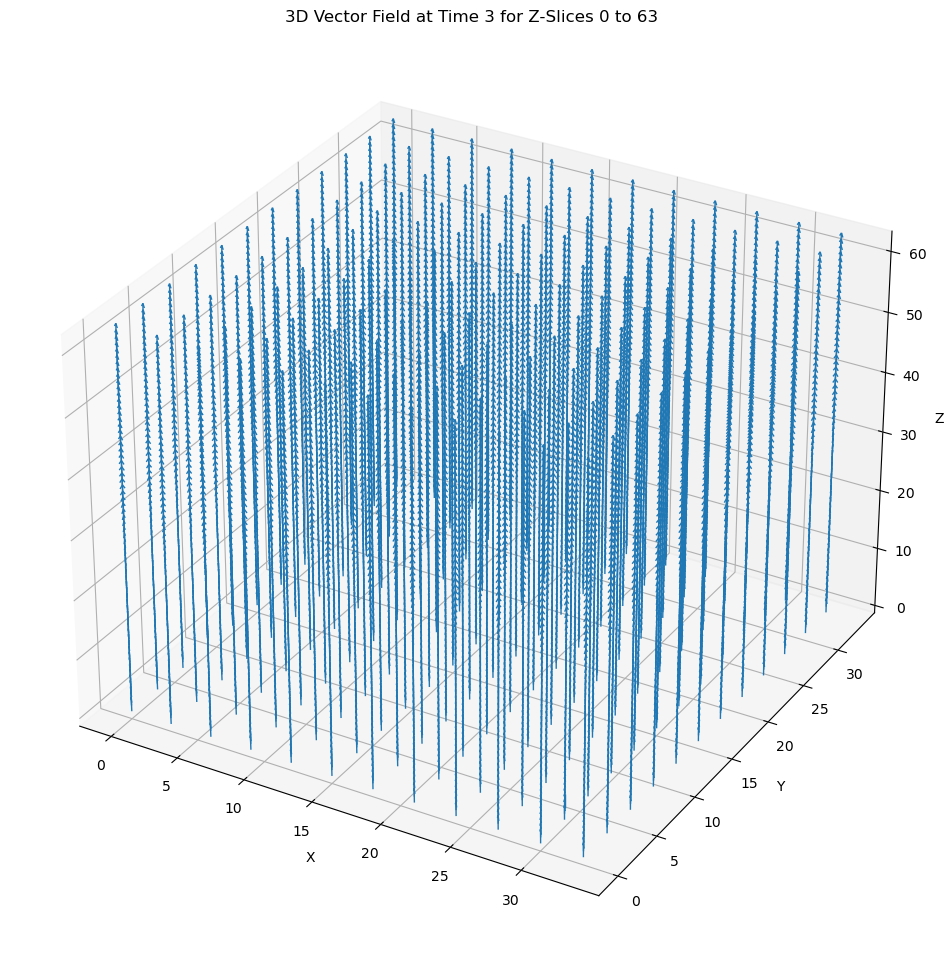

In [19]:
# Extracting vector components for time point t
t = 3 # replace with your desired time point
vx = straightened_rotated_vectors[:, :, :, t, 1]  # vx component
vy = straightened_rotated_vectors[:, :, :, t, 2]  # vy component
vz = straightened_rotated_vectors[:, :, :, t, 3]  # vz component

# Define the range of slices to visualize
start_slice = 0  # Starting slice number
end_slice = 63    # Ending slice number

# Set up the figure and 3D axis
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Sampling rate for arrows
n = 3  # Sample every nth arrow

# Plot vectors for each selected z-slice
for z in range(start_slice, end_slice + 1):
    x, y = np.meshgrid(np.arange(0, straightened_rotated_vectors.shape[0], n), np.arange(0, straightened_rotated_vectors.shape[1], n))
    ax.quiver(x, y, z, vx[::n, ::n, z].T, vy[::n, ::n, z].T, vz[::n, ::n, z].T, length=5, linewidths=1, arrow_length_ratio=0.3)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f"3D Vector Field at Time {t} for Z-Slices {start_slice} to {end_slice}")
# set limit z
#ax.set_zlim(20, 30)
# Show x-z plane
#ax.view_init(elev=0., azim=0.)
# Show y-z plane
#ax.view_init(elev=0., azim=90.)
# Show the plot
plt.show()


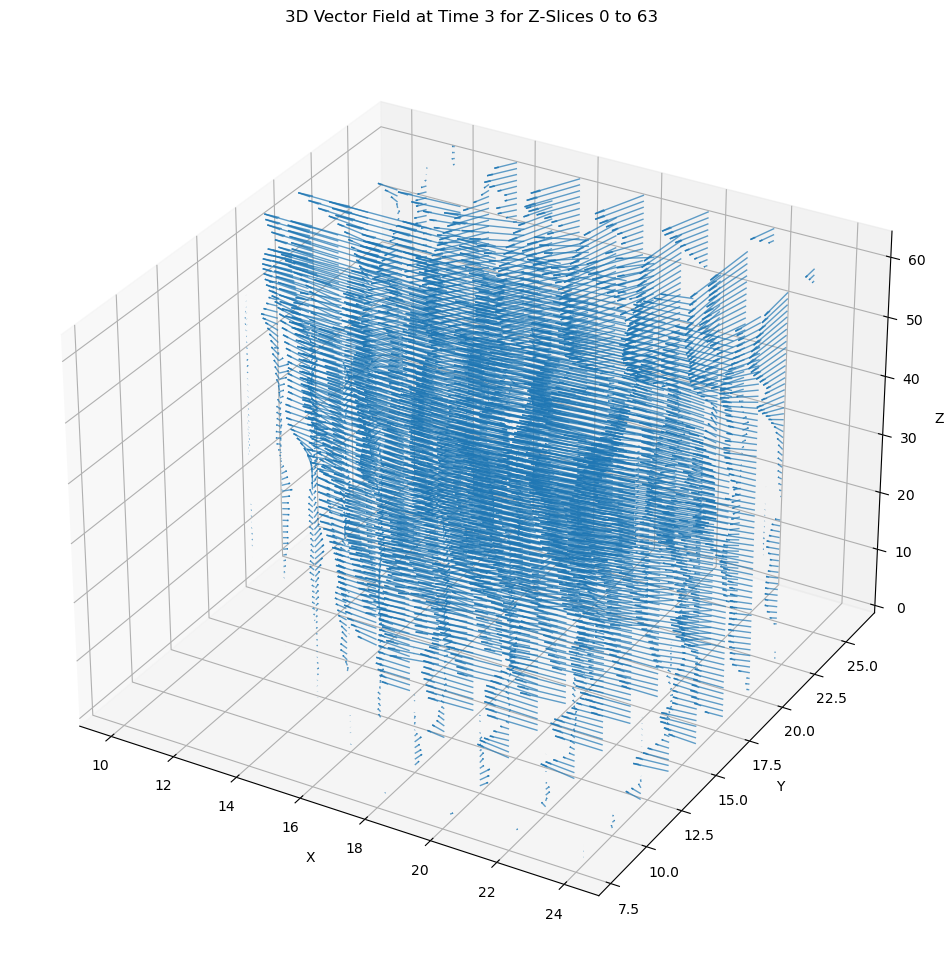

In [20]:
# Extracting vector components for time point t
t = 3  # replace with your desired time point
vx = straightened[:, :, :, t, 1]  # vx component
vy = straightened[:, :, :, t, 2]  # vy component
vz = straightened[:, :, :, t, 3]  # vz component

# Define the range of slices to visualize
start_slice =0  # Starting slice number
end_slice = 63   # Ending slice number

# Set up the figure and 3D axis
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Sampling rate for arrows
n = 2  # Sample every nth arrow

# Plot vectors for each selected z-slice
for z in range(start_slice, end_slice + 1):
    x, y = np.meshgrid(np.arange(0, straightened.shape[0], n), np.arange(0, straightened.shape[1], n))
    ax.quiver(x, y, z, vx[::n, ::n, z].T, vy[::n, ::n, z].T, vz[::n, ::n, z].T, length=4, linewidths=1, arrow_length_ratio=0.2, alpha = 0.7)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f"3D Vector Field at Time {t} for Z-Slices {start_slice} to {end_slice}")
#ax.set_zlim(0, 60)
# Show x-z plane

#ax.view_init(elev=0., azim=0.)

# Show y-z plane
#ax.view_init(elev=0., azim=90.)


# Show the plot
plt.show()


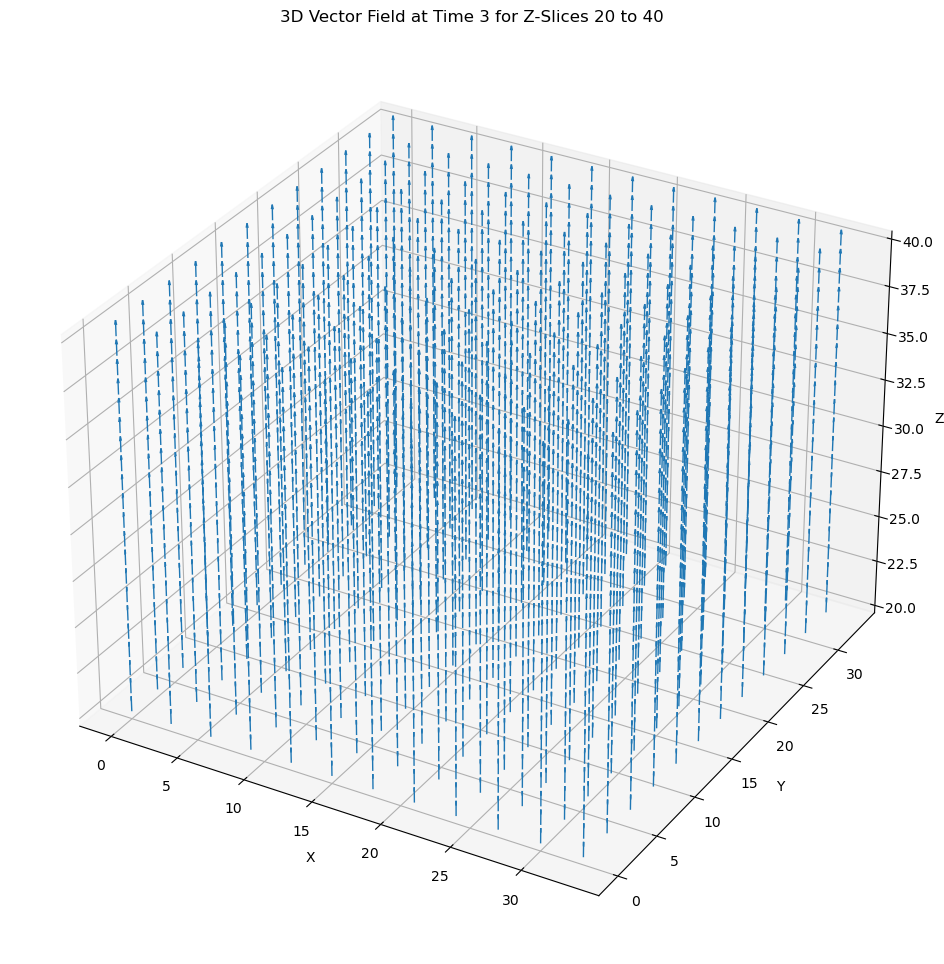

In [21]:
# Extracting vector components for time point t
t = 3 # replace with your desired time point
vx = straightened_rotated_vectors[:, :, :, t, 1]  # vx component
vy = straightened_rotated_vectors[:, :, :, t, 2]  # vy component
vz = straightened_rotated_vectors[:, :, :, t, 3]  # vz component

# Define the range of slices to visualize
start_slice = 20  # Starting slice number
end_slice = 40    # Ending slice number

# Set up the figure and 3D axis
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Sampling rate for arrows
n = 3  # Sample every nth arrow

# Plot vectors for each selected z-slice
for z in range(start_slice, end_slice + 1):
    x, y = np.meshgrid(np.arange(0, straightened_rotated_vectors.shape[0], n), np.arange(0, straightened_rotated_vectors.shape[1], n))
    ax.quiver(x, y, z, vx[::n, ::n, z].T, vy[::n, ::n, z].T, vz[::n, ::n, z].T, length=2, linewidths=1, arrow_length_ratio=0.3)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f"3D Vector Field at Time {t} for Z-Slices {start_slice} to {end_slice}")
# set limit z
#ax.set_zlim(20, 30)
# Show x-z plane
#ax.view_init(elev=0., azim=0.)
# Show y-z plane
#ax.view_init(elev=0., azim=90.)
# Show the plot
plt.show()
